# Kinyarwanda Text Auto-Completion Using a Bi-LSTM model, with Attention.

In [ ]:
!nvidia-smi # to see what GPU you have

Fri Dec  8 17:31:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchsummaryX

In [ ]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
#importing Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import os
import re
import random
import wandb
import torchsummaryX

import seaborn
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/filtered_datasets.zip

### Defining global variables and helper functions.

In [ ]:
DICTIONARY_PATH = "/content/drive/MyDrive/IDL Group Project/Dataset preparation/filtered_datasets_v2/dictionary.txt"
DICTIONARY_list =  np.loadtxt(DICTIONARY_PATH, dtype= str)
DICTIONARY_dict = {word: idx for idx, word in enumerate(DICTIONARY_list)}
SOS_IDX = DICTIONARY_dict["<sos>"]
EOS_IDX = DICTIONARY_dict["<eos>"]
UNK_IDX = DICTIONARY_dict["<unk>"]
print("SOS_IDX:",SOS_IDX,"EOS_IDX:",EOS_IDX,"UNK_IDX:", UNK_IDX)

SOS_IDX: 2 EOS_IDX: 1 UNK_IDX: 3


In [ ]:
def get_files_in_directory(directory_path):
    """
    This function returns a list of filenames in a
    specific directory path.
    """
    files = []
    for file in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, file)):
            files.append(file)
    return files

In [ ]:
PATH_TO_NPY_DATA = "/content/drive/MyDrive/IDL Group Project/Dataset preparation/filtered_datasets_v2/NP"
NPY_FILENAMES = sorted(get_files_in_directory(PATH_TO_NPY_DATA))
print(NPY_FILENAMES)

['corpus1.txt_10000_.npy', 'corpus1.txt_1000_.npy', 'corpus1.txt_100_.npy', 'corpus1.txt_10100_.npy', 'corpus1.txt_10200_.npy', 'corpus1.txt_10300_.npy', 'corpus1.txt_10400_.npy', 'corpus1.txt_10500_.npy', 'corpus1.txt_10600_.npy', 'corpus1.txt_10700_.npy', 'corpus1.txt_10800_.npy', 'corpus1.txt_10900_.npy', 'corpus1.txt_11000_.npy', 'corpus1.txt_1100_.npy', 'corpus1.txt_11100_.npy', 'corpus1.txt_11200_.npy', 'corpus1.txt_11300_.npy', 'corpus1.txt_11400_.npy', 'corpus1.txt_11500_.npy', 'corpus1.txt_11600_.npy', 'corpus1.txt_11700_.npy', 'corpus1.txt_11800_.npy', 'corpus1.txt_11900_.npy', 'corpus1.txt_12000_.npy', 'corpus1.txt_1200_.npy', 'corpus1.txt_12100_.npy', 'corpus1.txt_12200_.npy', 'corpus1.txt_12300_.npy', 'corpus1.txt_12400_.npy', 'corpus1.txt_12500_.npy', 'corpus1.txt_12600_.npy', 'corpus1.txt_12700_.npy', 'corpus1.txt_12800_.npy', 'corpus1.txt_12900_.npy', 'corpus1.txt_13000_.npy', 'corpus1.txt_1300_.npy', 'corpus1.txt_13100_.npy', 'corpus1.txt_13200_.npy', 'corpus1.txt_1330

### Train & Test data splitting

In [ ]:


#  Set a seed for reproducibility
random.seed(42)

# Shuffle the list of file names
random.shuffle(NPY_FILENAMES)

# Define the split ratio (e.g., 80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(NPY_FILENAMES) * split_ratio)

# Split the files into training and testing sets
train_files = NPY_FILENAMES[:split_index]
test_files = NPY_FILENAMES[split_index:]
train_files = [os.path.join(PATH_TO_NPY_DATA, i) for i in train_files]
test_files = [os.path.join(PATH_TO_NPY_DATA, i) for i in test_files]

### Creating the Datasets and Dataloaders Objects.

In [ ]:
#setting N-gram
N = 7

In [ ]:
class N_gramDataset(Dataset):
    def __init__(self, data_filepaths_list,
                 sos_idx=SOS_IDX, eos_idx=EOS_IDX,
                 sequence_length=100, max_output_rows=100,
                 shuffle=False):
        """
        Initializes the N-gram dataset object.
        :param data_filepaths_list: A list of filepaths to the data files.
        :param sos_idx: Index for the start of sequence token.
        :param eos_idx: Index for the end of sequence token.
        :param sequence_length: The length of the sequences to be generated.
        :param max_output_rows: Maximum number of rows to output in each batch.
        :param shuffle: Boolean indicating whether to shuffle the sequences.
        """
        self.data_filepaths_list = data_filepaths_list
        self.length = len(data_filepaths_list)
        self.sos_idx, self.eos_idx = sos_idx, eos_idx
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.max_output_rows = max_output_rows

    def __len__(self):
        """
        Returns the length of the dataset (number of files).
        """
        return self.length

    def __getitem__(self, idx):
        """
        Retrieves a batch of sequences from the dataset.
        :param idx: Index of the data file to load.
        :return: Tuple of input sequences and target sequences for training.
        """
        # Load sequences from the file at the given index
        filepath = self.data_filepaths_list[idx]
        sequences = np.load(filepath, allow_pickle=True)

        # Shuffle the sequences if required
        if self.shuffle:
            sequences = np.random.permutation(sequences)

        new_sequences = []

        # Process each sequence in the file
        for article_id, article_ in enumerate(sequences):
            # Append start and end tokens to each sequence
            new_sequences.append(torch.LongTensor(np.append(np.append(np.array([self.sos_idx]), article_), np.array([self.eos_idx]))))

        # Combine all sequences into a single tensor
        new_sequences = torch.cat(new_sequences)

        # Calculate the number of batches based on sequence length
        num_batches = len(new_sequences) // (self.sequence_length + 1)

        # Initialize tensor for storing batches
        X = torch.zeros((num_batches, self.sequence_length + 1), dtype=torch.long)

        # Fill the tensor with sequences
        for batch_idx in range(num_batches):
            start_idx = batch_idx * self.sequence_length
            end_idx = start_idx + self.sequence_length + 1
            X[batch_idx, :] = new_sequences[start_idx:end_idx]

        # Return the input and target sequences, limited by max_output_rows
        return X[:self.max_output_rows, :-1], X[:self.max_output_rows, 1:]


# Create datasets and dataloaders
train_dataset = N_gramDataset(data_filepaths_list= train_files,sequence_length=N,max_output_rows=28, shuffle = True)
val_dataset = N_gramDataset(data_filepaths_list= test_files,sequence_length=N, shuffle = False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [ ]:
#check the shapes of the loade dataset
for X__, y___ in train_loader:
  print(X__.shape, y___.shape)
  break

torch.Size([1, 28, 7]) torch.Size([1, 28, 7])


In [ ]:
print(X__[0][5], y___[0][5])

tensor([    2, 11976,  4712,  4828,     3,  1477,   841]) tensor([11976,  4712,  4828,     3,  1477,   841, 13124])


In [ ]:
# del model
torch.cuda.empty_cache()

### Defining the Model.

In [ ]:
class BiLSTM_N_gramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        """
        Initializes the BiLSTM N-gram Model.
        :param vocab_size: Size of the vocabulary.
        :param embedding_dim: Dimension of the word embeddings.
        :param hidden_size: Size of the hidden layers in the BiLSTM.
        """
        super(BiLSTM_N_gramModel, self).__init__()

        # Embedding layer to transform indices into dense vectors of a fixed size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # BiLSTM layer for processing sequences, bidirectional to capture forward and backward context
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

        # Multihead attention layer to focus on different positions in the sequence
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=1, dropout=0.0,
                                               batch_first=True)

        # Fully connected layers to map the output of the attention layer to the vocabulary size
        self.fc = torch.nn.Sequential(
            nn.Linear(hidden_size * 2, embedding_dim),
            nn.Linear(embedding_dim, vocab_size),
        )

    def forward(self, x):
        """
        Forward pass of the model.
        :param x: Input tensor containing sequences of word indices.
        :return: Logits for each word in the vocabulary and attention weights.
        """
        # Pass input through the embedding layer
        embedded = self.embedding(x)

        # Pass the embedded input through the BiLSTM layer
        output, _ = self.bilstm(embedded)

        # Apply the attention mechanism on the output of the BiLSTM
        attn_output, attn_output_weights = self.attention(query=output, key=output, value=output,
                                                          need_weights=True, average_attn_weights=True)

        # Pass the output of the attention layer through the fully connected layer
        logits = self.fc(attn_output)

        # Return the logits and the attention weights
        return logits, attn_output_weights


# Initialize the model
vocab_size = len(DICTIONARY_list)
embedding_dim = 300
hidden_size = 256

model = BiLSTM_N_gramModel(vocab_size, embedding_dim, hidden_size).to(DEVICE)


In [ ]:
vocab_size

18737

In [ ]:
print(model)
torchsummaryX.summary(model, x = X__[0].to(DEVICE))

BiLSTM_N_gramModel(
  (embedding): Embedding(18737, 300)
  (bilstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=18737, bias=True)
  )
)
               Kernel Shape    Output Shape   Params  Mult-Adds
Layer                                                          
0_embedding    [300, 18737]    [28, 7, 300]  5621100    5621100
1_bilstm                  -    [28, 7, 512]  1142784    1138688
2_fc.Linear_0    [512, 300]    [28, 7, 300]   153900     153600
3_fc.Linear_1  [300, 18737]  [28, 7, 18737]  5639837    5621100
---------------------------------------------------------------
                        Totals
Total params          12557621
Trainable params      12557621
Non-trainable params         0
Mult-Adds            

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[300, 18737]","[28, 7, 300]",5621100,5621100
1_bilstm,-,"[28, 7, 512]",1142784,1138688
2_fc.Linear_0,"[512, 300]","[28, 7, 300]",153900,153600
3_fc.Linear_1,"[300, 18737]","[28, 7, 18737]",5639837,5621100


### Initializing the Wandb businesses.

In [ ]:

wandb.login(key="")

wandb: Currently logged in as: uwizeyejeann (idl_djpr). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(
    name = f"lstm_attention_project_{N}_gram", #
    reinit = True, #l
    # id ='gin6p8tb', #
    # resume = "must", #
    project = "LSTM-attention-ablations", ### Print
    # config = config ### W0n
)

### Training & Evaluation

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Validation: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Epoch 1/20, Training Loss: 1.9942, Validation Loss: 1.6587, Training Accuracy: 0.7478, Validation Accuracy: 0.7936
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 29.97it/s]


Epoch 2/20, Training Loss: 1.1865, Validation Loss: 1.1737, Training Accuracy: 0.8406, Validation Accuracy: 0.8457
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 30.45it/s]


Epoch 3/20, Training Loss: 0.9983, Validation Loss: 1.0433, Training Accuracy: 0.8618, Validation Accuracy: 0.8614
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 20.04it/s]


Epoch 4/20, Training Loss: 0.9216, Validation Loss: 0.9889, Training Accuracy: 0.8699, Validation Accuracy: 0.8604


Validation: 100%|██████████| 4/4 [00:00<00:00, 31.99it/s]


Epoch 5/20, Training Loss: 0.8879, Validation Loss: 0.9692, Training Accuracy: 0.8741, Validation Accuracy: 0.8625
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 34.02it/s]


Epoch 6/20, Training Loss: 0.8631, Validation Loss: 0.9263, Training Accuracy: 0.8760, Validation Accuracy: 0.8675
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.19it/s]


Epoch 7/20, Training Loss: 0.8499, Validation Loss: 0.9242, Training Accuracy: 0.8772, Validation Accuracy: 0.8682
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 30.61it/s]


Epoch 8/20, Training Loss: 0.8382, Validation Loss: 0.9146, Training Accuracy: 0.8784, Validation Accuracy: 0.8679


Validation: 100%|██████████| 4/4 [00:00<00:00, 31.70it/s]


Epoch 9/20, Training Loss: 0.8265, Validation Loss: 0.9127, Training Accuracy: 0.8799, Validation Accuracy: 0.8686
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.30it/s]


Epoch 10/20, Training Loss: 0.8203, Validation Loss: 0.9079, Training Accuracy: 0.8800, Validation Accuracy: 0.8718
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 33.35it/s]


Epoch 11/20, Training Loss: 0.8131, Validation Loss: 0.9185, Training Accuracy: 0.8805, Validation Accuracy: 0.8661


Validation: 100%|██████████| 4/4 [00:00<00:00, 31.88it/s]


Epoch 12/20, Training Loss: 0.8124, Validation Loss: 0.9068, Training Accuracy: 0.8806, Validation Accuracy: 0.8689


Validation: 100%|██████████| 4/4 [00:00<00:00, 29.25it/s]


Epoch 13/20, Training Loss: 0.8032, Validation Loss: 0.8983, Training Accuracy: 0.8814, Validation Accuracy: 0.8700


Validation: 100%|██████████| 4/4 [00:00<00:00, 21.28it/s]


Epoch 14/20, Training Loss: 0.8029, Validation Loss: 0.8950, Training Accuracy: 0.8813, Validation Accuracy: 0.8711


Validation: 100%|██████████| 4/4 [00:00<00:00, 31.47it/s]


Epoch 15/20, Training Loss: 0.7989, Validation Loss: 0.9067, Training Accuracy: 0.8816, Validation Accuracy: 0.8668


Validation: 100%|██████████| 4/4 [00:00<00:00, 29.48it/s]


Epoch 16/20, Training Loss: 0.7960, Validation Loss: 0.8860, Training Accuracy: 0.8822, Validation Accuracy: 0.8732
Saving model


Validation: 100%|██████████| 4/4 [00:00<00:00, 31.89it/s]


Epoch 17/20, Training Loss: 0.7951, Validation Loss: 0.8926, Training Accuracy: 0.8819, Validation Accuracy: 0.8704


Validation: 100%|██████████| 4/4 [00:00<00:00, 33.11it/s]


Epoch 18/20, Training Loss: 0.7879, Validation Loss: 0.8828, Training Accuracy: 0.8825, Validation Accuracy: 0.8696


Validation: 100%|██████████| 4/4 [00:00<00:00, 22.77it/s]


Epoch 19/20, Training Loss: 0.7858, Validation Loss: 0.8781, Training Accuracy: 0.8830, Validation Accuracy: 0.8693


Validation: 100%|██████████| 4/4 [00:00<00:00, 33.26it/s]


Epoch 20/20, Training Loss: 0.7800, Validation Loss: 0.8686, Training Accuracy: 0.8828, Validation Accuracy: 0.8757
Saving model


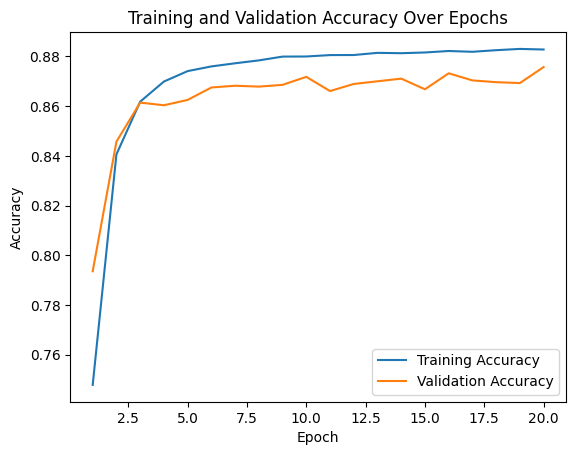

In [ ]:
# Initialize empty lists to store accuracy values
train_accuracies = []
val_accuracies = []
best_valacc = 0.0
num_epochs = 20

#training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training', dynamic_ncols=True)

    for inputs, targets in train_loader_iter:
        inputs = inputs[0].to(DEVICE)
        targets = targets[0].to(DEVICE)
        optimizer.zero_grad()
        outputs, attention_plot = model(inputs)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 2)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.numel()

    # Validation loss and accuracy
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_loader_iter = tqdm(val_loader, desc='Validation', dynamic_ncols=True)

        for inputs, targets in val_loader_iter:
            inputs = inputs[0].to(DEVICE)
            targets = targets[0].to(DEVICE)
            outputs, attention_plot = model(inputs)
            val_loss += criterion(outputs.view(-1, vocab_size), targets.view(-1)).item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 2)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.numel()

    average_train_loss = total_loss / len(train_loader)
    average_val_loss = val_loss / len(val_loader)

    # Calculate and store accuracies
    train_accuracy = correct_train / total_train
    val_accuracy = correct_val / total_val
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    if val_accuracy >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_acc': val_accuracy,
                  'epoch': epoch}, '/content/drive/MyDrive/IDL_dataset/checkpoints/LSTM_attention_checkpoint.pth')
      best_valacc = val_accuracy
      wandb.save('LSTM_attention_checkpoint.pth')
# Plot the accuracy curve
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
def save_model(model, optimizer, scheduler,  path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : None if scheduler is None else scheduler.state_dict(),
         'epoch'                    : epoch},
         path
    )

In [ ]:
save_model(model,
           optimizer,
           scheduler=None,
           path = f"/content/drive/MyDrive/IDL project/ATTENTION/{N}-gram.pth"
           )

In [ ]:
def plot_attention(attention):
    plt.clf()
    seaborn.heatmap(attention, cmap='GnBu')
    plt.show()

#### Attention plots (samples)

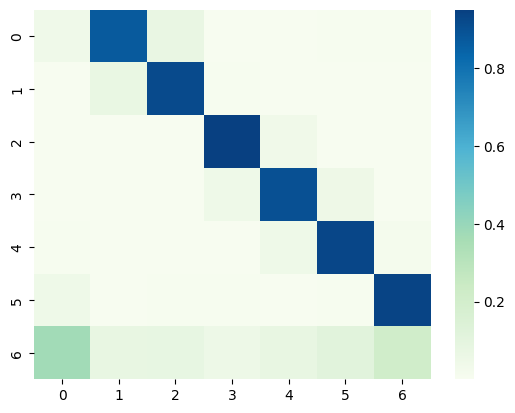

In [ ]:
plot_attention(attention_plot.mean(axis=0).cpu().detach().numpy())

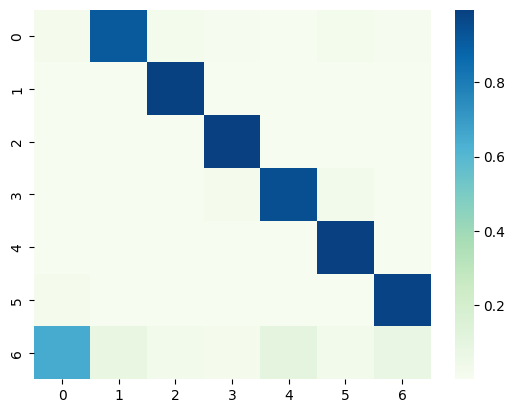

In [ ]:
plot_attention(attention_plot[0].cpu().detach().numpy())

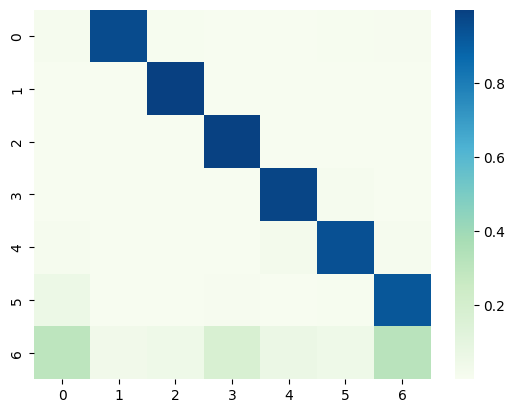

In [ ]:
plot_attention(attention_plot[1].cpu().detach().numpy())

In [ ]:
attention_plot.shape

torch.Size([28, 7, 7])

In [ ]:
attention_plot.mean(axis=0).shape

torch.Size([7, 7])

### Making inferences

In [ ]:
def predict_next_word(model, context, vocab_dict, index_dict, top_k = 3):
    model.eval()

    with torch.no_grad():
        # Convert context to indices
        context_indices = [vocab_dict.get(word, UNK_IDX) for word in context]
        input_tensor = torch.LongTensor(context_indices).unsqueeze(0)

        # Get model prediction
        output = model(input_tensor.to(DEVICE))
        # print(output.shape)
        predicted_index = torch.argmax(output[0, -1, :]).item()

        # Convert index to word
        predicted_word = index_dict.get(predicted_index, "<unk>")

        top_values, top_indices = torch.topk(torch.nn.Softmax(dim=0)(output[0, -1, :]), k=top_k)

        top_words = [index_dict.get(top_word, "<unk>") for top_word in top_indices.tolist()]


        top_k_dict = dict(zip(top_words, top_values.tolist()))

        print(f"Top {top_k} predicted words:\n", top_k_dict)

        return predicted_word

In [ ]:
ngram_to_index = DICTIONARY_dict
index_to_ngram = {value: key for key, value in DICTIONARY_dict.items()}

In [ ]:
# Example usage:
input_text = "Ubu bufatanye buratwongerera imbaraga mu"
input_context = ["<sos>"] + input_text.lower().split()
predicted_word = predict_next_word(model, input_context, ngram_to_index, index_to_ngram, top_k= 4)
print(f'Next word prediction: {predicted_word}')


Top 4 predicted words:
 {'<unk>': 0.052292946726083755, 'gukumira': 0.04070750251412392, 'kubaka': 0.03730732947587967, 'bikorwa': 0.030961250886321068}
Next word prediction: <unk>


In [ ]:
state_dict = torch.load("/content/LSTM_attention_checkpoint.pth",map_location=torch.device('cpu'))
model.load_state_dict(state_dict["model_state_dict"])

<All keys matched successfully>

#### Top-K accuracy Evaluation

In [ ]:
def validate(model, k=5):
      # Validation loss and accuracy
    from tqdm import tqdm
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        correct_val_top_k = 0
        total_val = 0
        val_loader_iter = tqdm(val_loader, desc='Validation', dynamic_ncols=True)

        for inputs, targets in val_loader_iter:
            inputs = inputs[0].to(DEVICE)
            targets = targets[0].to(DEVICE)
            outputs, attention_plot = model(inputs)
            val_loss += criterion(outputs.view(-1, vocab_size), targets.view(-1)).item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 2)
            correct_val += (predicted == targets).sum().item()
            _, topk_predicted = torch.topk(outputs, k, dim=2)
            correct_val_top_k += torch.any(topk_predicted == targets.view(targets.size(0), targets.size(1), 1), dim=2).sum().item()

            total_val += targets.numel()

    average_val_loss = val_loss / len(val_loader)

    # Calculate and store accuracies
    val_accuracy = correct_val / total_val
    val_k_accuracy = correct_val_top_k/ total_val
    return val_k_accuracy

In [ ]:
k_accuracies = [validate(model, k) for k in range(1,11)]

Validation: 100%|██████████| 331/331 [00:09<00:00, 35.95it/s]


In [ ]:
validate(model,1)

Validation: 100%|██████████| 331/331 [00:12<00:00, 25.81it/s]


0.00024114112886745412

In [ ]:
from tqdm import tqdm
val_loader_iter = tqdm(val_loader, desc='Validation', dynamic_ncols=True)

for inputs, targets in val_loader_iter:
    inputs = inputs[0].to(DEVICE)
    targets = targets[0].to(DEVICE)
    outputs, attention_plot = model(inputs)

Validation: 100%|██████████| 331/331 [00:09<00:00, 35.95it/s]


Text(3, 0.9, 'K=3, Top-K Accuracy=89.96%')

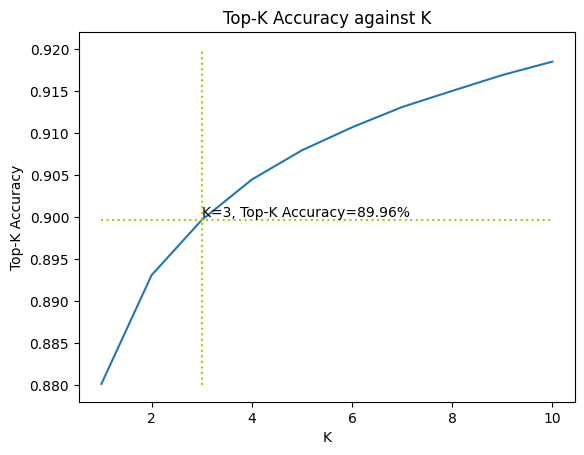

In [ ]:
plt.plot(np.arange(1,11), np.array(k_accuracies)[:,1] )
plt.title("Top-K Accuracy against K")
plt.xlabel("K")
plt.ylabel("Top-K Accuracy")
plt.plot([3,3],[0.88,0.92],"y:")
plt.plot([1,10],[0.8996,0.8996],"y:")
plt.annotate("K=3, Top-K Accuracy=89.96%",(3,.9))